In [1]:
from torchvision import models, transforms
from torchsummary import summary
import torch
import numpy as np
import cv2
import PIL
import matplotlib.pyplot as plt

from utils import *
from src import *

2024-11-26 16:42:17.485143: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 16:42:17.497078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732635737.511732   19859 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732635737.515856   19859 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 16:42:17.531038: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
model = models.resnet50(pretrained=True)
class_names = np.loadtxt('imagenet_classes.txt', str, delimiter='\t')

/home/jakub/Documents/Tasks/final/grad-cam/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jakub/Documents/Tasks/final/grad-cam/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


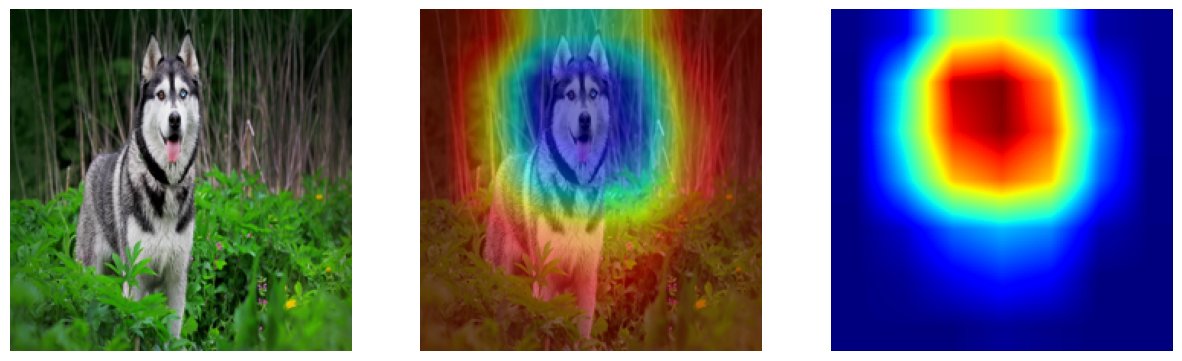

In [3]:
img = get_image_torch('images/husky.jpg', 224, 224)
cam_husky_our = get_hirescam(img, model, model.layer4[-1].conv3)
overlay_plot_torch(img, cam_husky_our, 0.5, 'images_prezentacja/hirescam_husky.png')

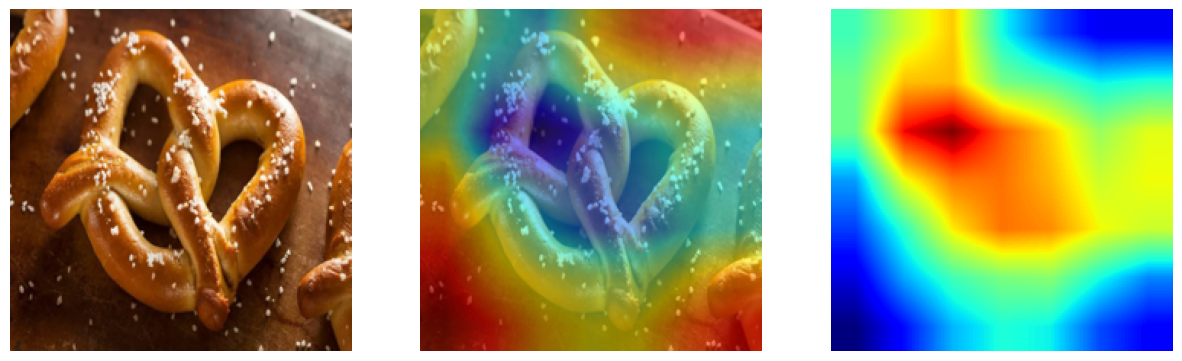

In [4]:
img = get_image_torch('images/precelek.jpg', 224, 224)
cam_pretzel_our = get_hirescam(img, model, model.layer4[-1].conv3)
overlay_plot_torch(img, cam_pretzel_our, 0.5, 'images_prezentacja/hirescam_precel.png')

In [5]:
from pytorch_grad_cam import GradCAM, HiResCAM, AblationCAM, ScoreCAM, GradCAMPlusPlus, XGradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
from utils import *
from src import *

In [6]:
model = resnet50(pretrained=True)
target_layers = [model.layer4[-1].conv3]

/home/jakub/Documents/Tasks/final/grad-cam/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jakub/Documents/Tasks/final/grad-cam/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


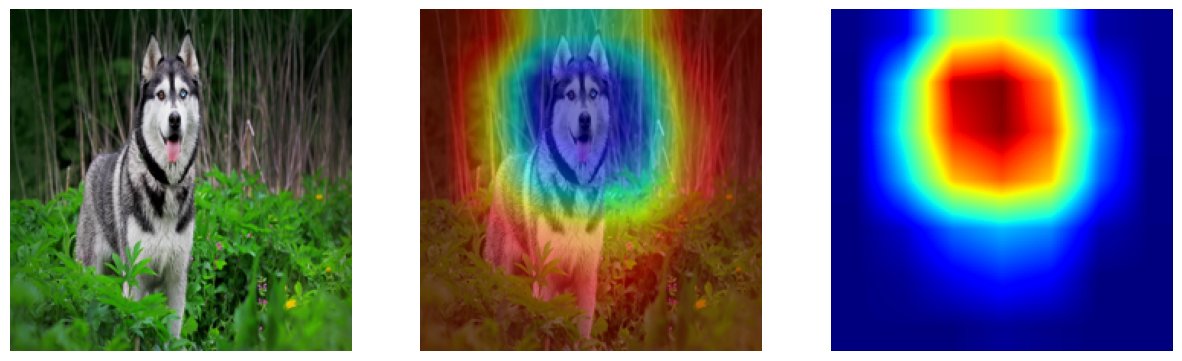

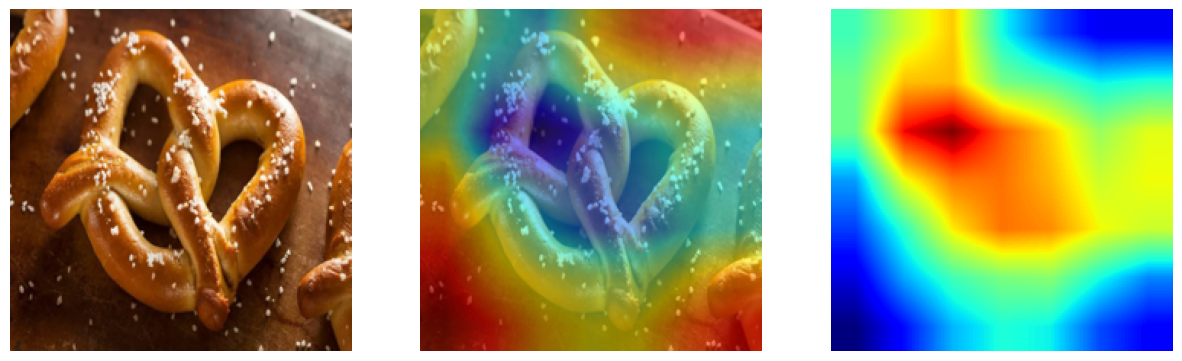

In [7]:
input_tensor = get_image_torch('images/husky.jpg', 224, 224).unsqueeze(0)
targets = [ClassifierOutputTarget(250)]

with HiResCAM(model=model, target_layers=target_layers) as cam:
  cam_husky_lib = cam(input_tensor=input_tensor, targets=targets).squeeze(0)
overlay_plot_torch(input_tensor.squeeze(), cam_husky_lib, 0.5, 'images_prezentacja/hirescam_husky_lib.png')

input_tensor = get_image_torch('images/precelek.jpg', 224, 224).unsqueeze(0)
targets = [ClassifierOutputTarget(932)]

with HiResCAM(model=model, target_layers=target_layers) as cam:
  cam_pretzel_lib = cam(input_tensor=input_tensor, targets=targets).squeeze(0)
overlay_plot_torch(input_tensor.squeeze(), cam_pretzel_lib , 0.5, 'images_prezentacja/hirescam_precel_lib.png')

In [8]:
cam_husky_our = cv2.resize(cam_husky_our, (224, 224))
cam_pretzel_our = cv2.resize(cam_pretzel_our, (224, 224))

In [11]:
np.mean((cam_husky_our - cam_husky_lib)**2), np.mean((cam_pretzel_our - cam_pretzel_lib)**2)

(0.005742329, 0.05168549)

In [13]:
from skimage.metrics import structural_similarity as ssim
# 1 identyczne 
# -1 rozna

ssim(cam_husky_our, cam_husky_lib, data_range=cam_husky_our.max() - cam_husky_our.min()), ssim(cam_pretzel_our, cam_pretzel_lib, data_range=cam_pretzel_our.max() - cam_pretzel_our.min())

(0.9739661796991897, 0.816335509620013)

In [16]:
np.mean(np.abs(cam_husky_our - cam_husky_lib)), np.mean(np.abs(cam_pretzel_our - cam_pretzel_lib))

(0.049330134, 0.20709926)

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
# 1 identyczne
# 0 brak

cosine_similarity(cam_husky_our.reshape(1, -1), cam_husky_lib.reshape(1, -1)), cosine_similarity(cam_pretzel_our.reshape(1, -1), cam_pretzel_lib.reshape(1, -1))

(array([[0.99999994]], dtype=float32), array([[0.9999999]], dtype=float32))